In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Install and Import Required Libraries

In [45]:
!pip install rasterio
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import rasterio
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Load and Explore the Dataset

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


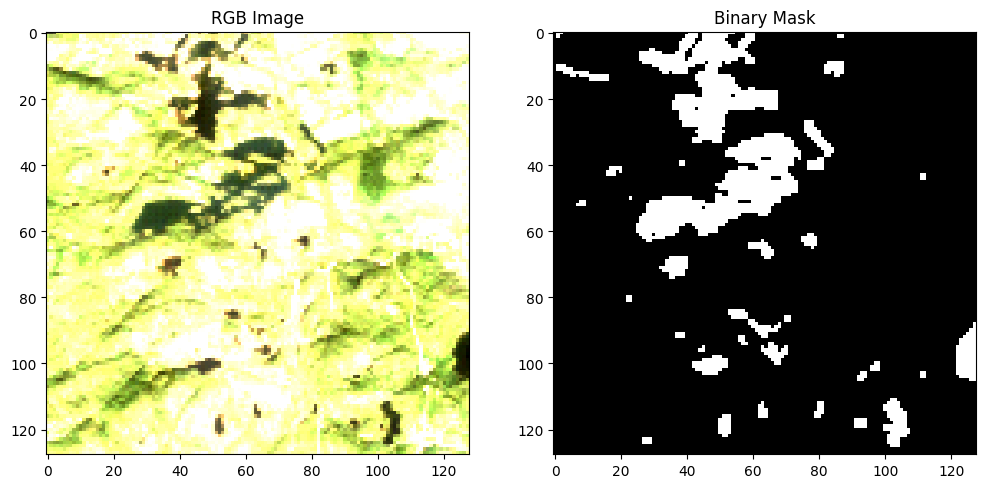

In [46]:

data_dir = "/content/drive/My Drive/Computer_Vision_intern/week_3/data"
image_paths = [os.path.join(data_dir, "images", f"{i}.tif") for i in range(306)]
mask_paths = [os.path.join(data_dir, "labels", f"{i}.png") for i in range(456)]

def visualize_sample(image_path, mask_path):
    with rasterio.open(image_path) as img:
        image = img.read()
        image = np.transpose(image, (1, 2, 0))

    mask = np.array(Image.open(mask_path))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, [3, 2, 1]])
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Binary Mask")
    plt.show()

# Visualize a sample
visualize_sample(image_paths[0], mask_paths[0])

# Preprocessing

In [47]:
def normalize(image):
    return image / 10000.0

class WaterDataset:
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.image_paths[idx]) as img:
            image = img.read()
            image = np.transpose(image, (1, 2, 0))
            image = normalize(image)
        mask = np.array(Image.open(self.mask_paths[idx]))
        mask = np.expand_dims(mask, axis=-1)
        return image, mask

min_length = min(len(image_paths), len(mask_paths))
image_paths = image_paths[:min_length]
mask_paths = mask_paths[:min_length]

# Split dataset into train, validation, and test
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths,
                                                                                          mask_paths,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths,
                                                                                        train_mask_paths,
                                                                                        test_size=0.2,
                                                                                        random_state=42)

# Create data set
train_dataset = WaterDataset(train_image_paths, train_mask_paths)
val_dataset = WaterDataset(val_image_paths, val_mask_paths)
test_dataset = WaterDataset(test_image_paths, test_mask_paths)

# Convert data set to tensorflow data set
def tf_dataset(dataset):
    images = np.array([dataset[i][0] for i in range(len(dataset))])
    masks = np.array([dataset[i][1] for i in range(len(dataset))])
    return tf.data.Dataset.from_tensor_slices((images, masks))

train_tf_dataset = tf_dataset(train_dataset).batch(8).prefetch(tf.data.AUTOTUNE)
val_tf_dataset = tf_dataset(val_dataset).batch(8).prefetch(tf.data.AUTOTUNE)
test_tf_dataset = tf_dataset(test_dataset).batch(8).prefetch(tf.data.AUTOTUNE)

# Define the U-Net Model

In [50]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.concatenate([up1, conv2], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([up2, conv1], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat2)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

model = unet_model(input_shape=(128, 128, 12))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 64, 64, 64)     │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_79[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 32, 32, 128)    │              0 │ conv2d_80[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_81[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_14          │ (None, 64, 64, 256)    │              0 │ conv2d_82[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 64, 64, 384)    │              0 │ up_sampling2d_14[0][0… │
│ (Concatenate)             │                        │                │ conv2d_80[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 64, 64, 128)    │        442,496 │ concatenate_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_83[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_15          │ (None, 128, 128, 128)  │              0 │ conv2d_84[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 128, 128, 192)  │              0 │ up_sampling2d_15[0][0… │
│ (Concatenate)             │                        │                │ conv2d_78[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 128, 128, 64)   │        110,656 │ concatenate_15[0][0]   │
├──────────────────────

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

# Check the shape of a sample

In [51]:
sample_image, sample_mask = next(iter(train_tf_dataset))
print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

Image shape: (8, 128, 128, 12)
Mask shape: (8, 128, 128, 1)


# **Train the Model**

In [38]:
# Train the model
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 298s 12s/step - accuracy: 0.8974 - loss: 0.3057 - val_accuracy: 0.8734 - val_loss: 0.3440
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 310s 12s/step - accuracy: 0.9075 - loss: 0.2758 - val_accuracy: 0.8736 - val_loss: 0.3794
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 327s 13s/step - accuracy: 0.9088 - loss: 0.2584 - val_accuracy: 0.8723 - val_loss: 0.4127
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 300s 12s/step - accuracy: 0.9089 - loss: 0.2529 - val_accuracy: 0.8769 - val_loss: 0.3412
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 283s 11s/step - accuracy: 0.9112 - loss: 0.2453 - val_accuracy: 0.8790 - val_loss: 0.3193
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 269s 11s/step - accuracy: 0.9114 - loss: 0.2433 - val_accuracy: 0.8790 - val_loss: 0.3334
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - accuracy: 0.9110 - loss: 0.2436 - val_accuracy: 0.8799 - val_loss: 0.3006
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 270s 11s/step - accuracy: 0.9114 - loss: 0.2366 - val_accuracy: 0.

# **Evaluate the Model**

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_tf_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9059 - loss: 0.2559
Test Loss: 0.22162818908691406
Test Accuracy: 0.9214733242988586


# **Visualize Results**

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Function to compute metrics
def compute_metrics(model, dataset):
    y_true = []
    y_pred = []

    for images, masks in dataset:
        pred_masks = model.predict(images, verbose=0)
        pred_masks = (pred_masks > 0.5).astype(np.uint8)

        y_true.extend(masks.numpy().flatten())
        y_pred.extend(pred_masks.flatten())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)

    return precision, recall, f1, iou

# Compute metrics on the test set
precision, recall, f1, iou = compute_metrics(model, test_tf_dataset)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.9283
Recall: 0.7936
F1-Score: 0.8557
IoU: 0.7477


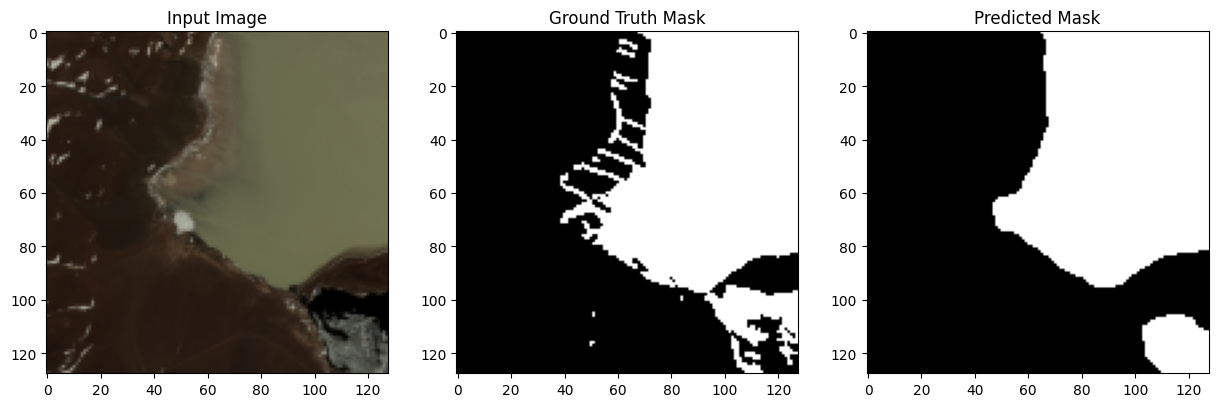

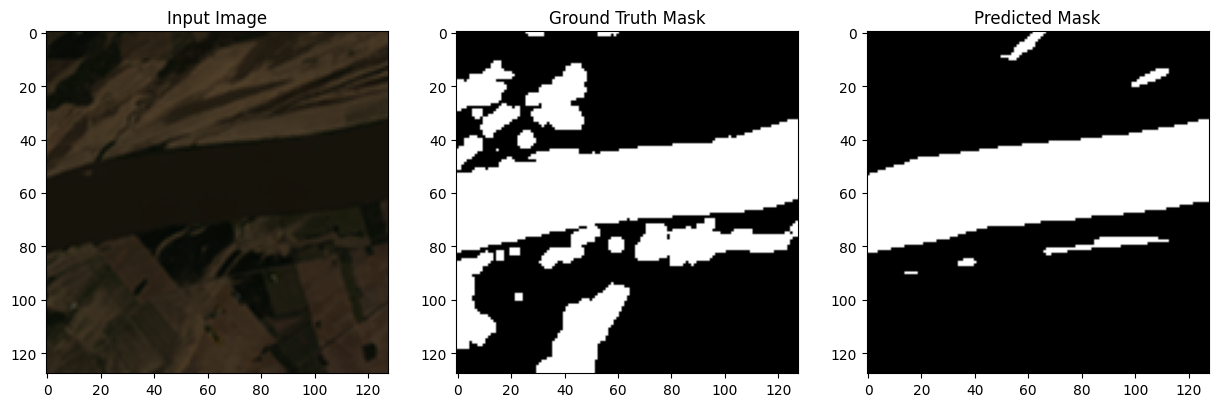

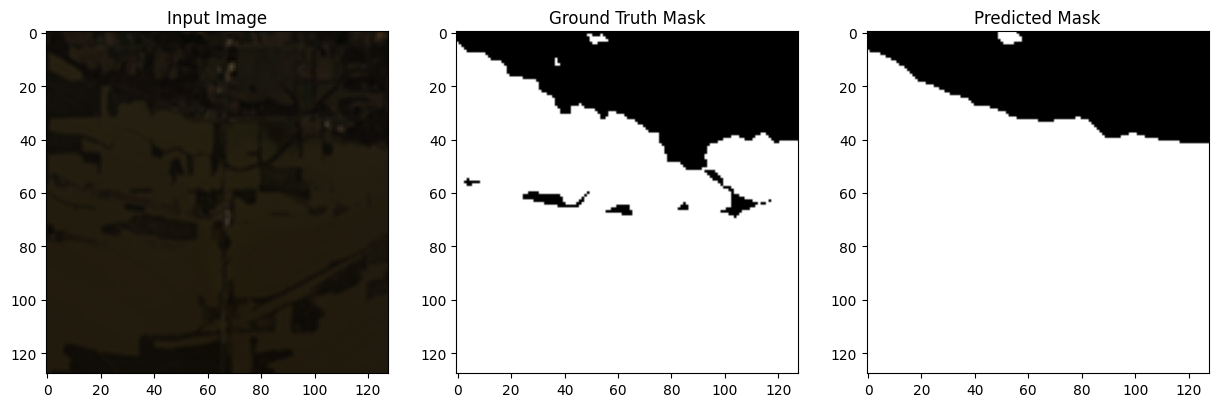

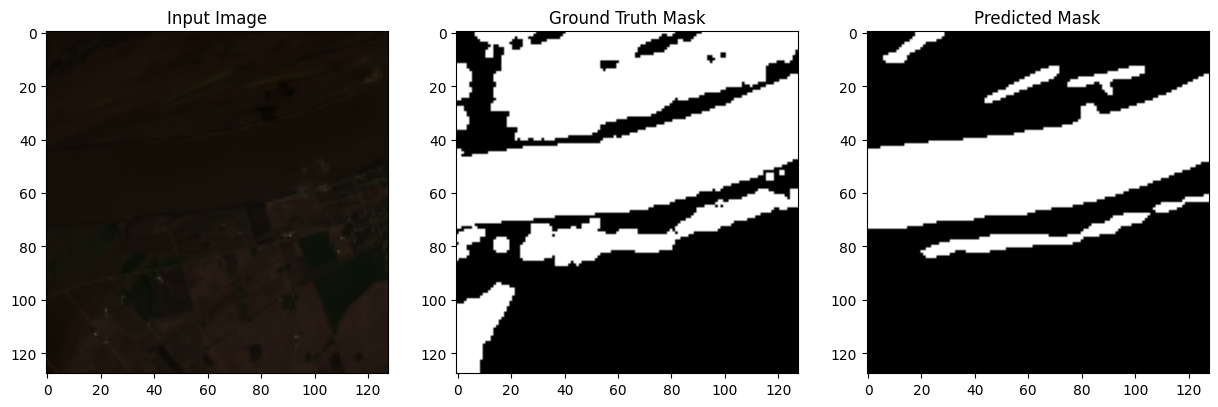

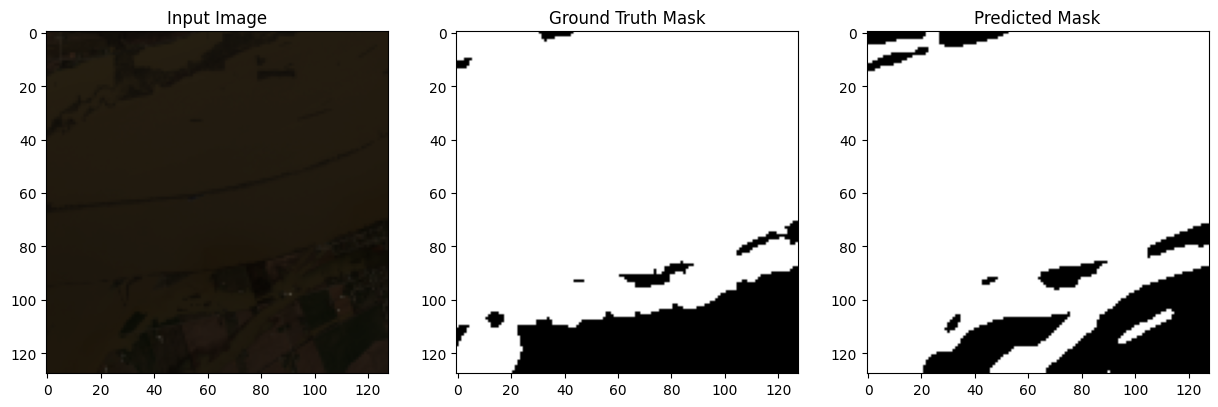

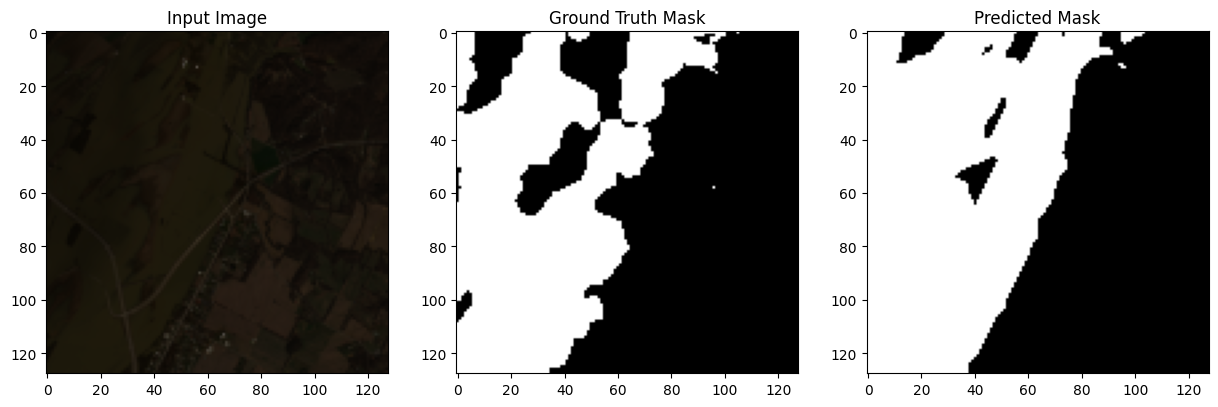

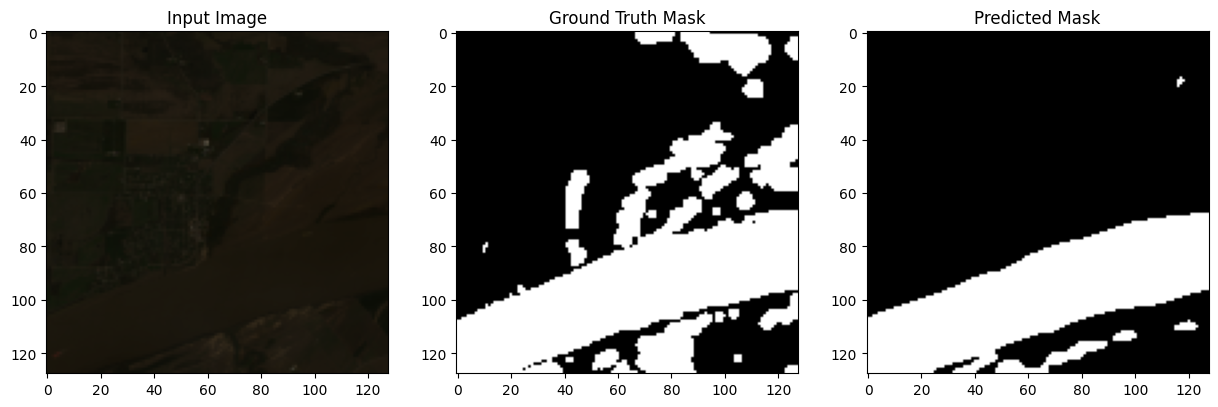

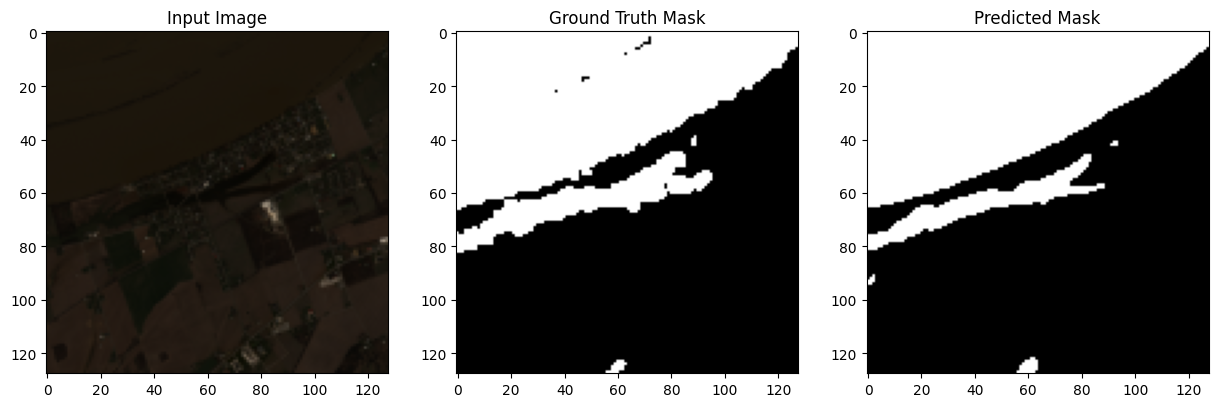

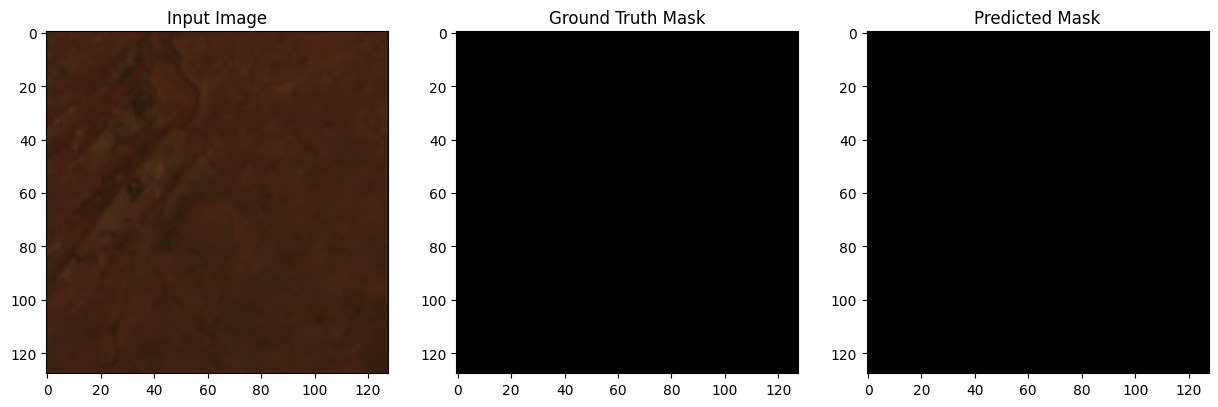

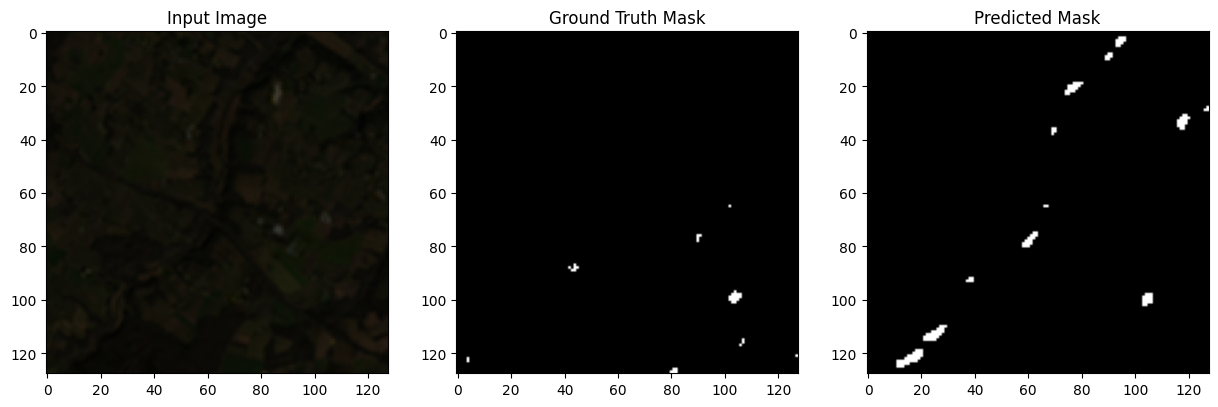

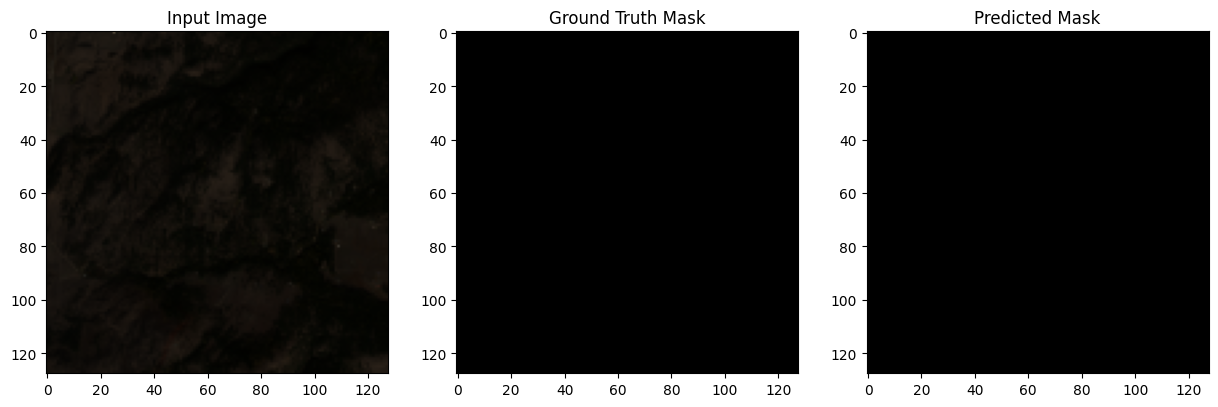

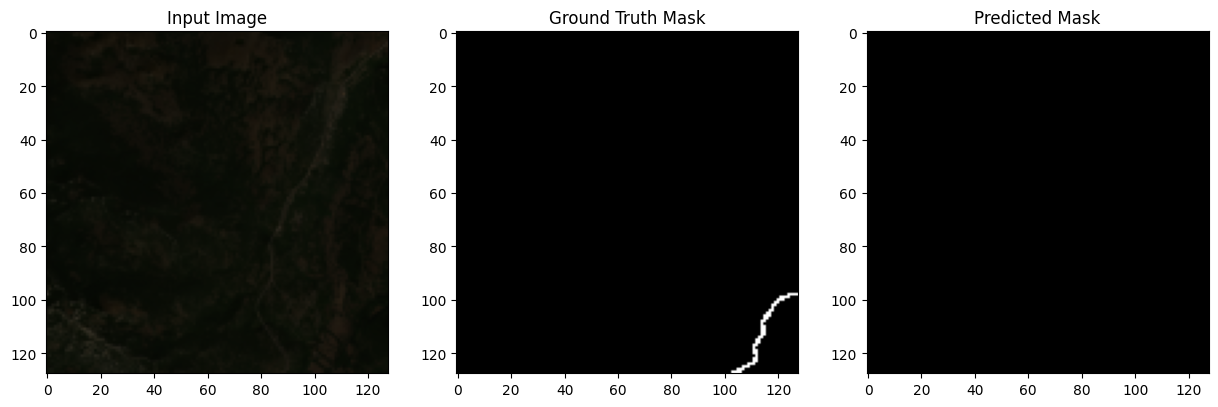

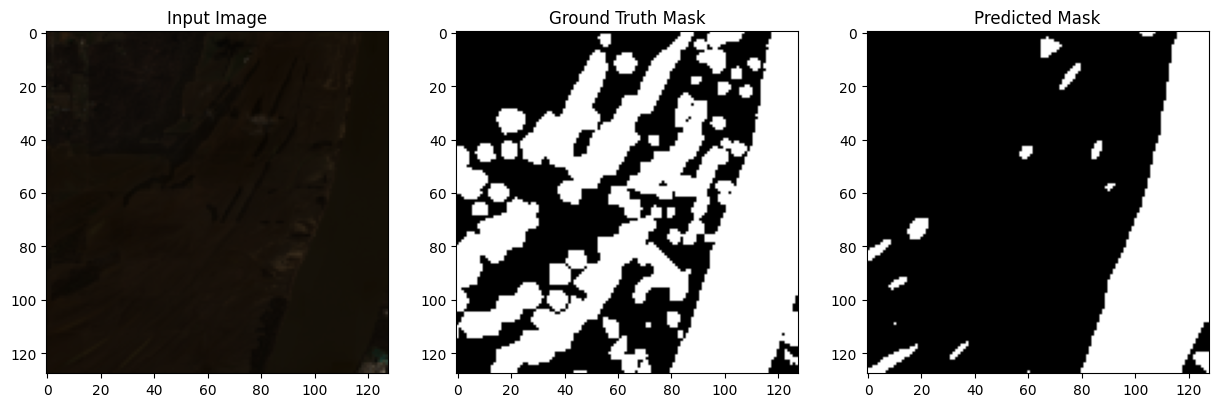

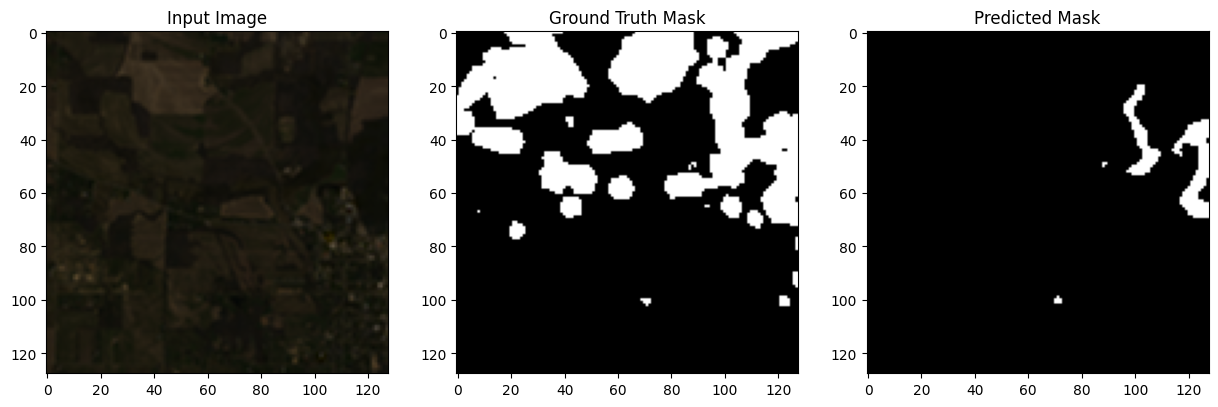

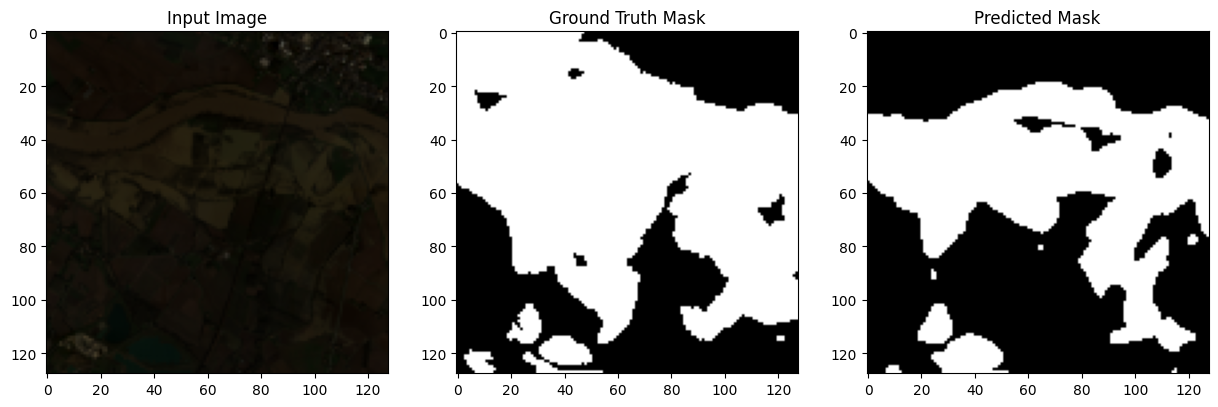

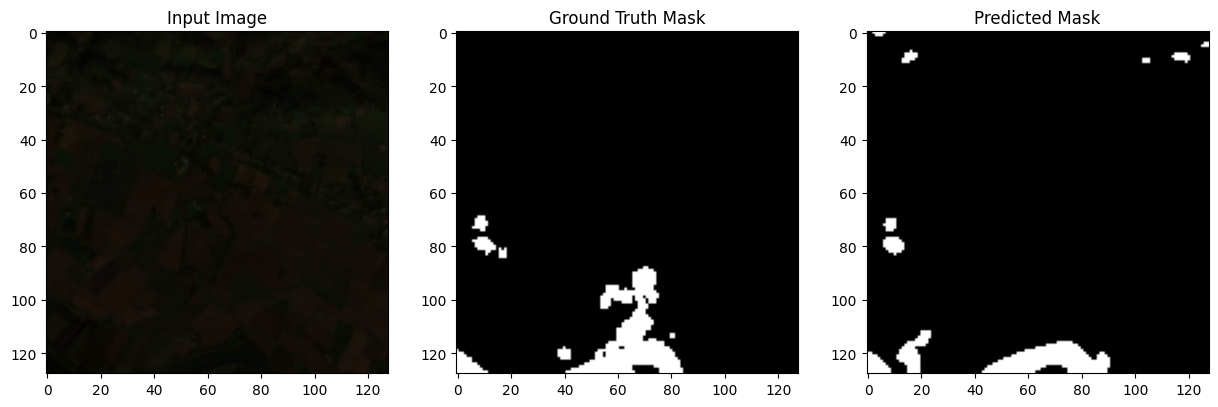

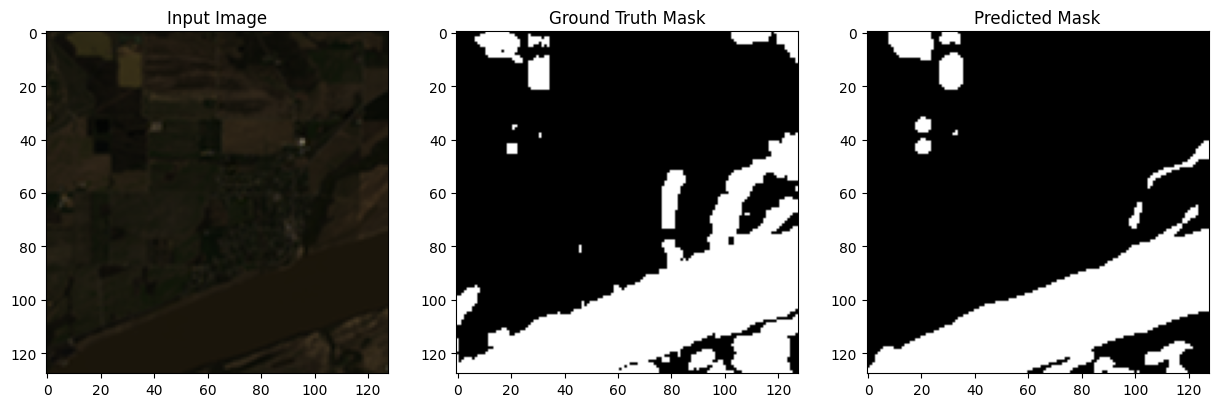

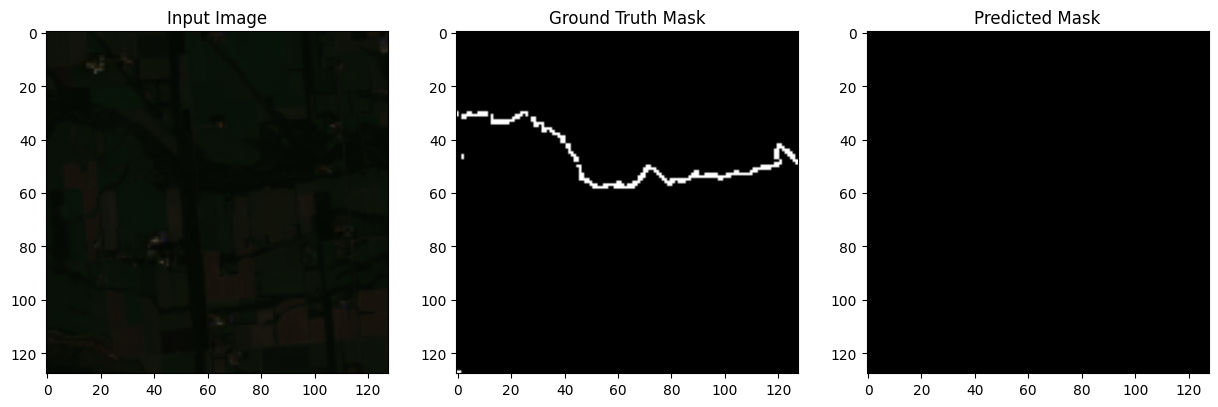

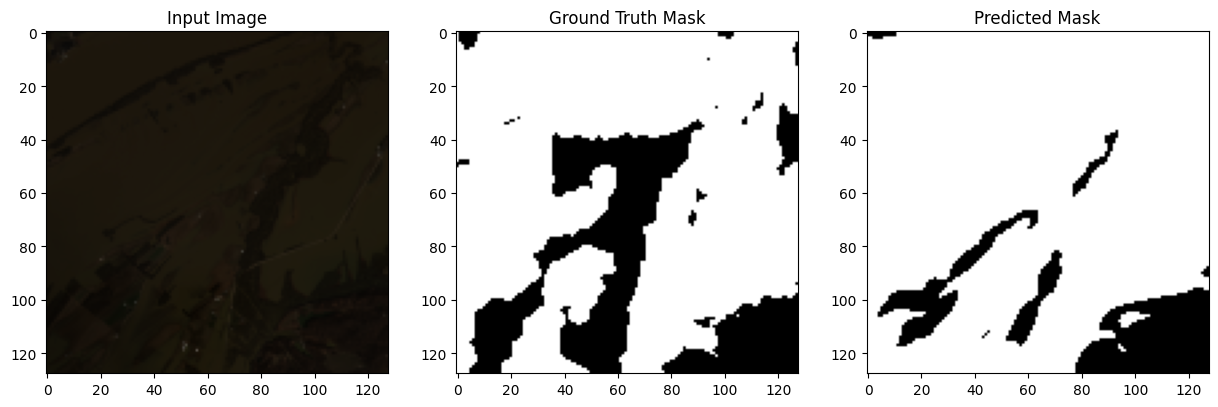

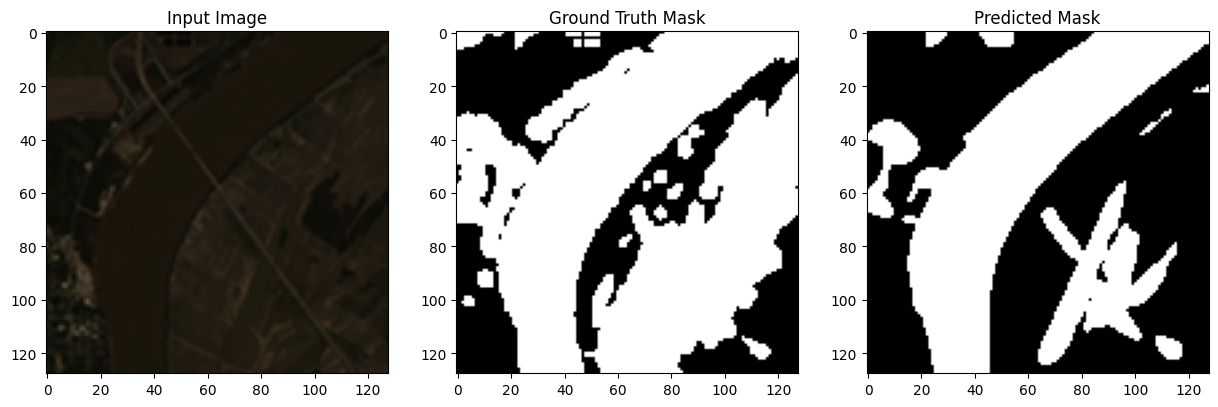

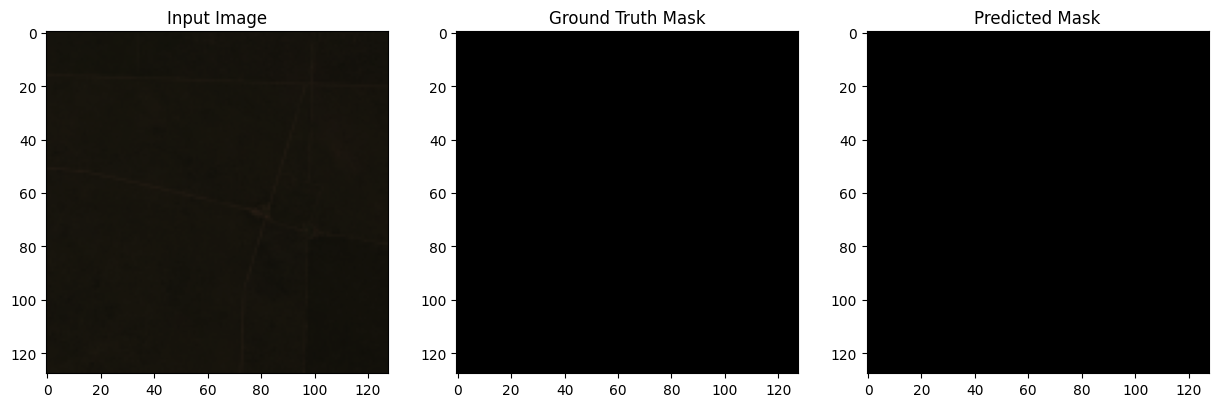

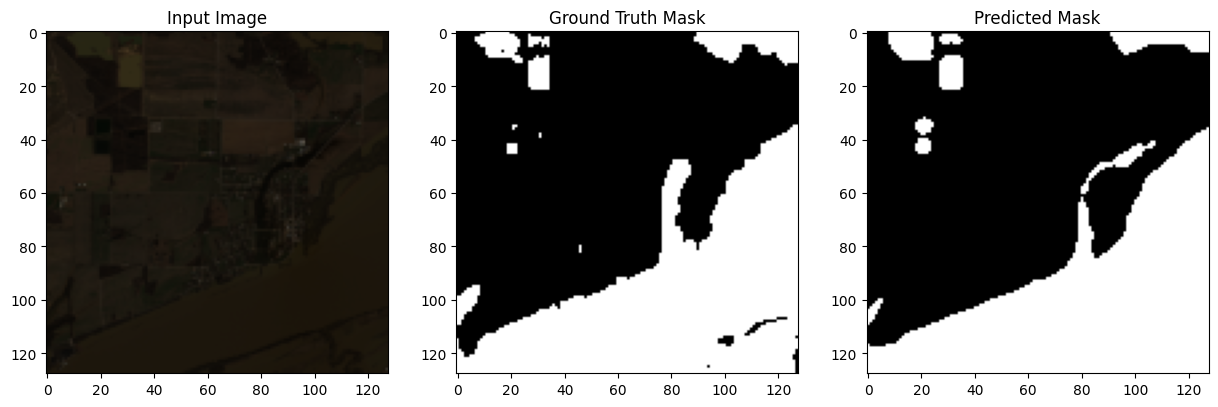

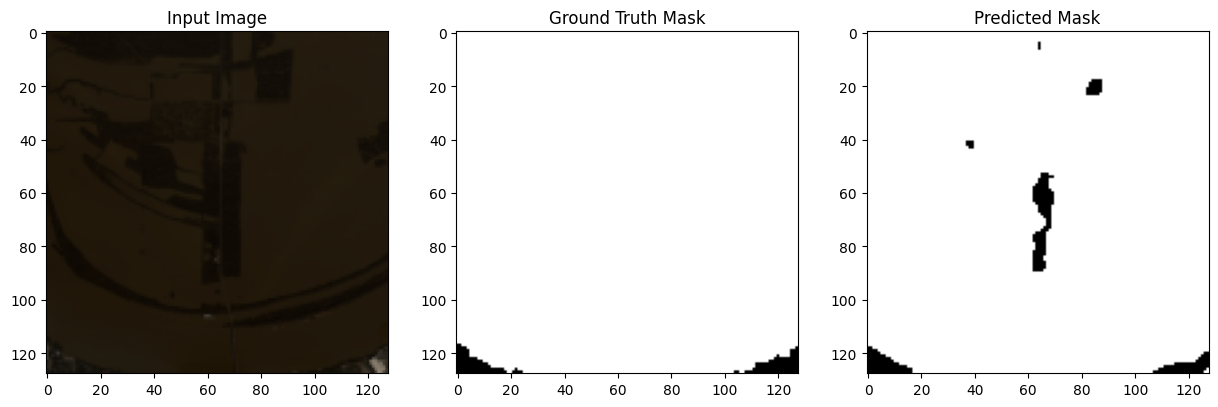

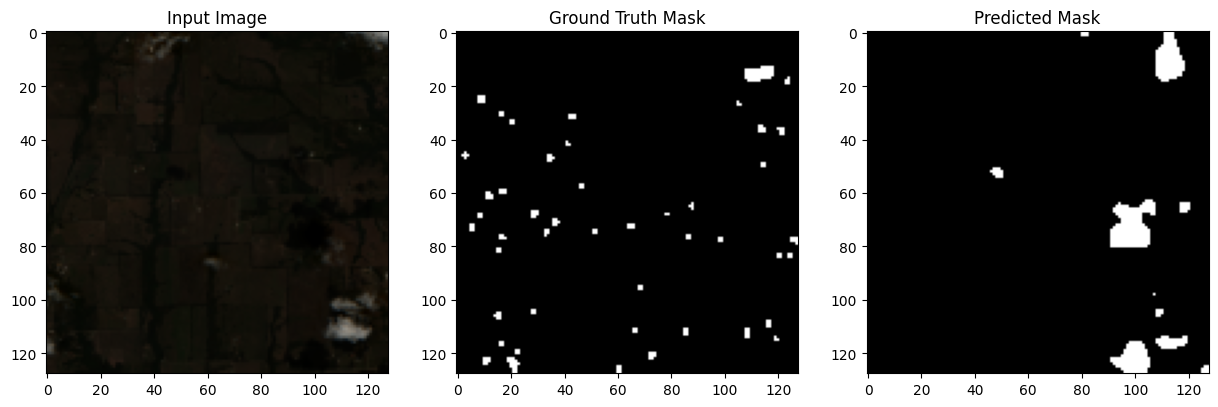

In [41]:
# Plot predictions
def plot_predictions(model, dataset, num_samples=3):
    for images, masks in dataset.take(num_samples):
        pred_masks = model.predict(images, verbose=0)
        pred_masks = (pred_masks > 0.5).astype(np.uint8)

        for i in range(len(images)):
            plt.figure(figsize=(15, 5))

            # Input Image (RGB bands)
            plt.subplot(1, 3, 1)
            plt.imshow(images[i].numpy()[:, :, [3, 2, 1]])
            plt.title("Input Image")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy()[:, :, 0], cmap="gray")
            plt.title("Ground Truth Mask")

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_masks[i][:, :, 0], cmap="gray")
            plt.title("Predicted Mask")

            plt.show()

# Visualize predictions
plot_predictions(model, test_tf_dataset)